In [1]:
# importamos o pandas
import pandas as pd
# importamos o cplex
from docplex.mp.model import Model

In [2]:
# vamos resolver o problema do planejamento de força de trabalho
# para isso, vamos coletar e armazenar informações sobre o problema em um DataFrame
# estas informações são retiradas da descrição do problema nas notas de aula

data = pd.DataFrame(columns=["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"])
data.loc["Demanda"] = [14, 13, 15, 16, 19, 18, 11]
data

,Seg,Ter,Qua,Qui,Sex,Sáb,Dom
Demanda,14,13,15,16,19,18,11


In [3]:
# vamos relacionar cada dia da semana com os inícios de jornada
# que ajudam a satisfazer sua demanda

# tem um jeito mais esperto de fazer isso?

work_on = {"Seg" : ("Seg", "Qui", "Sex", "Sáb", "Dom"),
           "Ter" : ("Ter", "Sex", "Sáb", "Dom", "Seg"),
           "Qua" : ("Qua", "Sáb", "Dom", "Seg", "Ter"),
           "Qui" : ("Qui", "Dom", "Seg", "Ter", "Qua"),
           "Sex" : ("Sex", "Seg", "Ter", "Qua", "Qui"),
           "Sáb" : ("Sáb", "Ter", "Qua", "Qui", "Sex"),
           "Dom" : ("Dom", "Qua", "Qui", "Sex", "Sáb")}

In [4]:
# agora vamos criar o modelo matemático para nosso problema

model = Model()

In [5]:
# adicionamos uma variável para cada dia da semana
x = {day : model.integer_var() for day in data.columns}
x

{'Seg': docplex.mp.Var(type=I),
 'Ter': docplex.mp.Var(type=I),
 'Qua': docplex.mp.Var(type=I),
 'Qui': docplex.mp.Var(type=I),
 'Sex': docplex.mp.Var(type=I),
 'Sáb': docplex.mp.Var(type=I),
 'Dom': docplex.mp.Var(type=I)}

In [6]:
# agora vamos criar as restrições

for day in data.columns:
    model.add_constraint(
        sum(x[start_day] for start_day in work_on[day]) >= data[day].Demanda)

In [7]:
# definimos a função-objetivo

model.minimize(sum(x[day] for day in data.columns))

In [8]:
# resolvemos o modelo

sol = model.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Found incumbent of value 48.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIP has 7 rows, 7 columns, and 35 nonzeros.
Reduced MIP has 0 binaries, 7 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.01 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 7 rows, 7 columns, and 35 nonzeros.
Reduced MIP has 0 binaries, 7 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (0.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           48.0000    

In [9]:
sol.display()

solution for: docplex_model1
objective: 22
x1 = 4
x2 = 7
x3 = 1
x4 = 7
x6 = 3


In [10]:
# vamos salvar a solução em data

data.loc["Iniciam jornada"] = [x[day].solution_value for day in data.columns]
data

,Seg,Ter,Qua,Qui,Sex,Sáb,Dom
Demanda,14,13,15,16,19,18,11
Iniciam jornada,4,7,1,7,0,3,0


In [11]:
# vamos verificar quantos trabalhadores temos disponíveis em cada dia da semana

data.loc["Trabalhadores Disponíveis"] = [sum(data[start_day]["Iniciam jornada"]
                                             for start_day in work_on[day])
                                         for day in data.columns]
data

,Seg,Ter,Qua,Qui,Sex,Sáb,Dom
Demanda,14,13,15,16,19,18,11
Iniciam jornada,4,7,1,7,0,3,0
Trabalhadores Disponíveis,14,14,15,19,19,18,11


In [12]:
# bem, a gente pode até ficar satisfeito com os dados da solução
# sendo apresentados dessa forma
# no entanto, é melhor apresentar a solução como um gráfico

data.plot.bar()

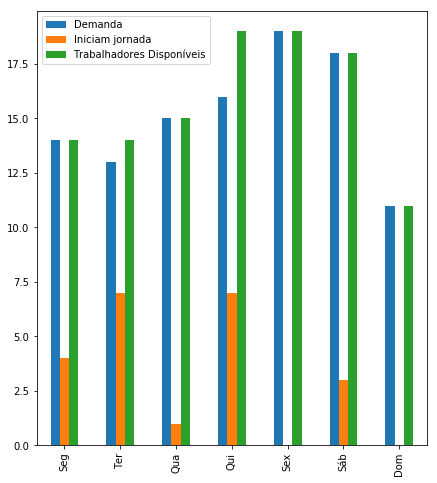

In [13]:
# parece que é melhor plotar o transposto de data:
# não queremos agrupar as colunas, e sim as linhas

data_transposed = data.transpose()
data_transposed.plot.bar(figsize=(7, 8))

In [14]:
# em quais dias temos mais trabalhadores que o necessário?
# note que os dois dias com mais demanda não têm sua demanda satisfeita com folga
# no entanto, o terceiro dia com mais demanda usa mais trabalhadores que o necessário.

# vamos supor que o seguinte é razoável:
# se a nossa solução ótima satisfaz com folga algumas demandas, é preferível que
# essas folgas aconteçam nos três dias com mais demanda.

# desafio que não vale nada, mas pode ser bom para vc pensar um pouco:
# como faríamos para incentivar o modelo a ter uma solução ótima cujas
# folgas são encorajadas a ocorrer nos dias com mais demanda?